In [23]:
import pandas as pd
import numpy as np

def q_damage(
    q_level: int,
    stats: dict[str, float],
    target_armor: float = 0,
    target_magic_resistance: float = 0,
    crit_multiplier: float = 1.75,

):
    q_level_damage = [30, 60, 90, 120, 150]
    q_damage = q_level_damage[q_level - 1] + stats["ad"] * 0.5
    crit_adjusted_q_damage = q_damage * (crit_multiplier * stats["crit_chance"] + (1-stats["crit_chance"]))
    return crit_adjusted_q_damage

def e_turn_damage(
    e_level: int,
    stats: dict[str, float],
    target_armor: float = 0,
    target_magic_resistance: float = 0,
    crit_multiplier: float = 1.4, # if IE built then 1.72
    # reminder: if hit by e spins 6 times, armour is reduced by 25%
    # garen spins around 7 + 1 per 25% bonus attack speed times over 3 seconds
):
    e_level_damage_far = [4, 8, 12, 16, 20]
    e_level_ad_scaling_far = [0.36, 0.38, 0.4, 0.42, 0.44]
    e_level_damage_near = [5, 10, 15, 20, 25]
    e_level_ad_scaling_near = [0.45, 0.475, 0.5, 0.525, 0.55]
    e_near_dmg = e_level_damage_near[e_level - 1] + stats["ad"] * e_level_ad_scaling_near[e_level - 1]
    e_far_dmg = e_level_damage_far[e_level - 1] + stats["ad"] * e_level_ad_scaling_far[e_level - 1]
    
    crit_adjust = crit_multiplier * stats["crit_chance"] + (1-stats["crit_chance"])

    [near_dmg, far_dmg] = [e_near_dmg, e_far_dmg]*crit_adjust
    return [near_dmg, far_dmg]

def get_total_spins(stats_row):
    bonus_as = stats_row['bonus_attack_speed']
    # Each 0.25 (25%) adds 1 spin
    extra_spins = int(bonus_as // 4)
    return 7 + extra_spins
    
def r_damage(
    r_level: int,
    percentage_dmg_multiplier: float,
    target_health: float,
    target_max_health: float,
):
    r_level_damage = [150, 250, 350]
    r_level_punish = [0.25, 0.3, 0.35]
    missing_health = target_max_health - target_health
    r_damage = r_level_damage[r_level - 1] + percentage_dmg_multiplier * missing_health * r_level_punish[r_level - 1]
    return r_damage

In [24]:
def calculate_stat(base, growth, level):
    if level == 1:
        return base
    # Official League of Legends growth formula
    multiplier = (level - 1) * (0.7025 + 0.0175 * (level - 1))
    return round(base + growth * multiplier, 2)

levels = np.arange(1, 19)

garen_stats = pd.DataFrame({
    "level": levels,
    "ad": [calculate_stat(69, 4.5, lvl) for lvl in levels],
    "crit_chance": [0] * 18,
    "health": [calculate_stat(690, 98, lvl) for lvl in levels],
    "armor": [calculate_stat(38, 4.2, lvl) for lvl in levels],
    "magic_resistance": [calculate_stat(32, 1.55, lvl) for lvl in levels],
    "base_attack_speed": [0.625] * 18,
    "bonus_attack_speed": [round((lvl - 1) * (0.7025 + 0.0175 * (lvl - 1)) * 0.0365, 4) for lvl in levels]
})

garen_stats.head()

,level,ad,crit_chance,health,armor,magic_resistance,base_attack_speed,bonus_attack_speed
0,1,69.00,0,690.00,38.00,32.00,0.625,0.0000
1,2,72.24,0,760.56,41.02,33.12,0.625,0.0263
2,3,75.64,0,834.55,44.20,34.29,0.625,0.0538
3,4,79.19,0,911.97,47.51,35.51,0.625,0.0827
4,5,82.90,0,992.82,50.98,36.79,0.625,0.1128


In [25]:
# testing block
q_damage(q_level = 1, stats = garen_stats)

0      64.500
1      66.120
2      67.820
3      69.595
4      71.450
5      73.390
6      75.400
7      77.495
8      79.665
9      81.915
10     84.245
11     86.650
12     89.140
13     91.700
14     94.345
15     97.070
16     99.870
17    102.750
dtype: float64

In [26]:
from items import shop_item, active_item

beserkers_greaves = shop_item(
    name="Beserker's Greaves",
    price = 1100,
    stats = {
        "bonus_attack_speed": 25,
        "move_speed": 45,
    },
    item_type = "boots")

dorans_blade = shop_item(
    name="Doran's Blade",
    price = 450,
    stats = {
        "ad": 10,
        "health": 80,
    },
    item_type = "starter")

dorans_shield = shop_item(
    name="Doran's Shield",
    price = 450,
    stats = {
        "health": 110,
    },
    item_type = "starter")

phantom_dancer = shop_item(
    name="Phantom Dancer",
    price = 2650,
    stats = {
        "crit_chance": 0.25,
        "bonus_attack_speed": 0.6,
        "percent_move_speed": 0.08
    })

stride_breaker = active_item(
    name="Stride Breaker",
    price = 3300,
    stats = {
        "ad": 40,
        "health": 450,
        "bonus_attack_speed": 0.25
        # active damage = 0.4*ad
    },
    item_type = "cleave")

dead_mans_plate = shop_item(
    name="Dead Man's Plate",
    price=2900,
    stats={
        "health": 300,
        "armor": 45,
        "percent_move_speed": 0.05,
        "slow_resistance": 0.25
    })

infinity_edge = shop_item(
    name="Infinity Edge",
    price = 3450,
    stats = {
        "ad": 65,
        "crit_chance": 0.25
        # +40% crit damage
    })

black_cleaver = shop_item(
    name="Black Cleaver",
    price=3000,
    stats={
        "ad": 55,
        "health": 400,
        "haste": 20,
        "armor_shred_per_stack": 0.06, # Max 30% reduction (5 stacks)
    },
    item_type = "pen")

lord_dominiks_regards = shop_item(
    name="Lord Dominik's Regards",
    price=3200,
    stats={
        "ad": 45,
        "crit_chance": 0.25,
        "armor_pen": 0.35
    },
    item_type = "pen")

trinity_force = shop_item(
    name="Trinity Force",
    price=3333,
    stats={
        "ad": 36,
        "bonus_attack_speed": 0.33,
        "health": 300,
        "haste": 20,
        "move_speed_on_hit": 20
        # Passive (Spellblade): Next attack deals 200% Base AD
        # Passive (Quicken): Basic attacks grant Move Speed
    },
    item_type = "sheen")

rapid_firecannon = shop_item(
    name="Rapid Firecannon",
    price=2600,
    stats={
        "bonus_attack_speed": 0.35,
        "crit_chance": 0.25,
        "percent_move_speed": 0.07,
        # Passive (Energized): Moving/Attacking generates a shock
        # Passive (Sniper): Increases range of Decisive Strike (Q) by 150
    })


In [27]:
def buy_item(base_stats_row, 
items: list[shop_item] = []):
    """
    Adds item stats to a specific level's base stats.
    Only adds stats that exist as columns in the base_stats_row.
    """
    new_stats = base_stats_row.copy()
    
    for item in items:
        for stat_name, value in item.stats.items():
            if stat_name in new_stats.index:
                new_stats[stat_name] += value

    return new_stats

lvl_11_base = garen_stats.iloc[10]
lvl_11_with_stride = buy_item(lvl_11_base, [stride_breaker])

print(f"Base AD at Lvl 11: {lvl_11_base['ad']}")
print(f"AD with Stridebreaker: {lvl_11_with_stride['ad']}")
print(q_damage(q_level = 1, stats = lvl_11_base))
print(q_damage(q_level = 1, stats = lvl_11_with_stride))

Base AD at Lvl 11: 108.49
AD with Stridebreaker: 148.49
84.245
104.245


### Model assuming:
<ol>
<li>lvl 18, full 5 points in Q</li>
<li>can sell boots and doesn't have to buy stride breaker</li>
<li>target with no armor and no magic resistance</li>
<li>spellblade and % damage increase not considered</li>
</ol>

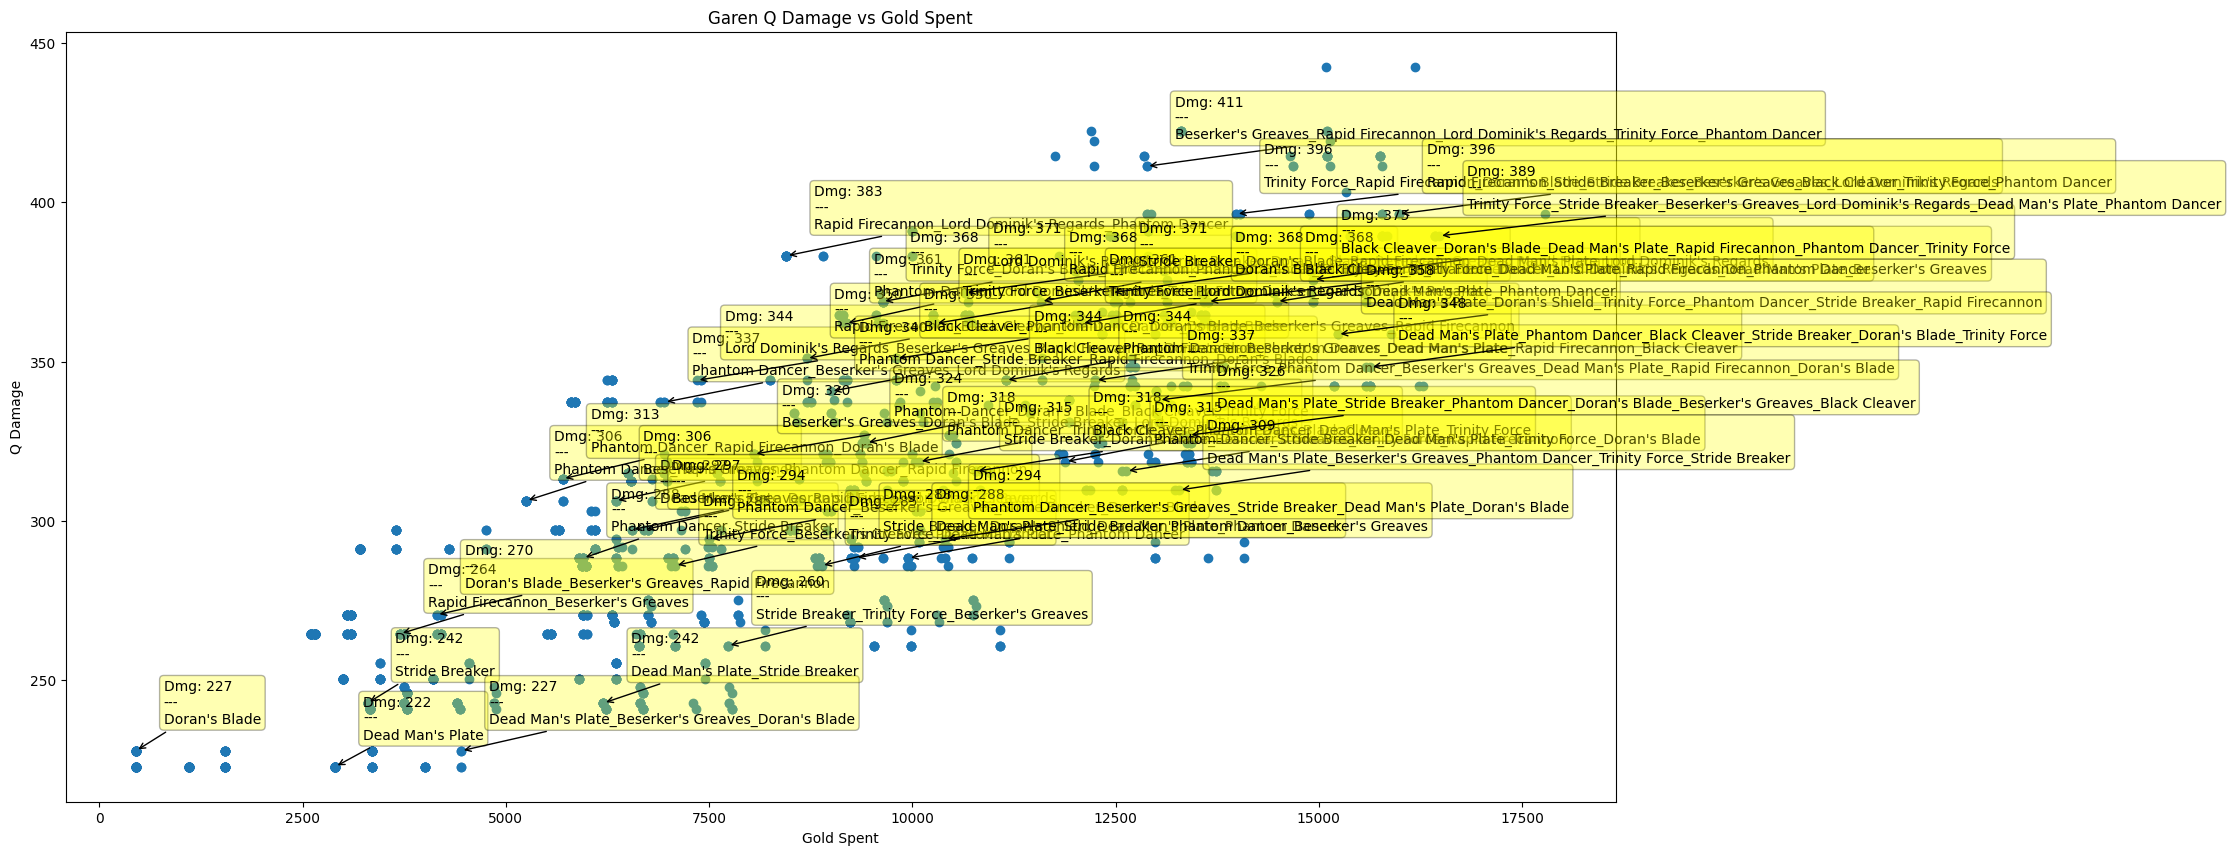

In [28]:
import matplotlib.pyplot as plt
import random


# Garen Level 18 Stats
BASE_AD_L18 = garen_stats.iloc[17]['ad']
items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards]   
results = []

for _ in range(2000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        item_name = "_".join([item.name for item in build])
        build_stats = buy_item(garen_stats.iloc[17], build)
        gold = sum([item.price for item in build])
        q_dmg = q_damage(q_level = 5, stats = build_stats)
        results.append({"gold": gold, "q_damage": q_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['q_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('Q Damage')
plt.title('Garen Q Damage vs Gold Spent')

# Extract the frontier points (best build for every 200g spent)
frontier = df_sim.loc[df_sim.groupby('gold')['q_damage'].idxmax()]

# Annotating specific spikes with a 'bbox' (text box) for readability
for idx, row in frontier.iloc[::5].iterrows(): # Step through bins
    build_label = row['items']
    plt.annotate(
        f"Dmg: {int(row['q_damage'])}\n---\n{build_label}", 
        (row['gold'], row['q_damage']),
        xytext=(20, 20), textcoords="offset points",
        bbox=dict(boxstyle='round', fc='yellow', alpha=0.3),
        arrowprops=dict(arrowstyle='->')
    ) 

plt.show()

In [29]:
import plotly.express as px

df_sim['build_display'] = df_sim['items'].str.replace("_", "<br>")

fig = px.scatter(
    df_sim, 
    x="gold", 
    y="q_damage",
    color="gold", # Color points by gold spent
    hover_name="q_damage", # Title of the tooltip
    hover_data={
        "gold": ":.0f",        # Show gold with 0 decimals
        "q_damage": ":.2f",    # Show damage with 2 decimals
        "build_display": True, # Show the item names
        "items": False         # Hide the ugly underscore version
    },
    labels={
        "gold": "Gold Spent",
        "q_damage": "Expected Q Damage",
        "build_display": "Items"
    },
    title="Interactive Garen Build Analysis: Hover to explore builds",
    template="plotly_dark"
)

# This helps see the optimal path visually
frontier = df_sim.loc[df_sim.groupby(df_sim['gold'] // 200 * 200)['q_damage'].idxmax()].sort_values('gold')
fig.add_scatter(
    x=frontier['gold'], 
    y=frontier['q_damage'], 
    mode='lines', 
    name='Efficiency Frontier',
    line=dict(color='red', width=2, dash='dot'),
    hoverinfo='skip'
)

fig.show()

In [31]:
import matplotlib.pyplot as plt
import random

items_pool = [
 stride_breaker, beserkers_greaves, dorans_blade, dorans_shield, dead_mans_plate, phantom_dancer, trinity_force,
 black_cleaver, rapid_firecannon, lord_dominiks_regards]   
results = []

for _ in range(2000):
    num_items = random.randint(1, 6)
    build = random.sample(items_pool, num_items)
    item_types = [item.item_type for item in build if item.item_type is not None]

    if len(item_types) == len(set(item_types)):
        item_name = "_".join([item.name for item in build])
        build_stats = buy_item(garen_stats.iloc[17], build)
        gold = sum([item.price for item in build])
        e_turn_dmg = e_turn_damage(e_level = 5, stats = build_stats)
        e_turns = get_total_spins(stats = build_stats)
        e_dmg = e_turn_dmg * e_turns
        results.append({"gold": gold, "e_damage": e_dmg, "items": item_name})
    else:
        continue

df_sim = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df_sim['gold'], df_sim['q_damage'])

plt.xlabel('Gold Spent')
plt.ylabel('Q Damage')
plt.title('Garen Q Damage vs Gold Spent')

# Extract the frontier points (best build for every 200g spent)
frontier = df_sim.loc[df_sim.groupby('gold')['q_damage'].idxmax()]

# Annotating specific spikes with a 'bbox' (text box) for readability
for idx, row in frontier.iloc[::5].iterrows(): # Step through bins
    build_label = row['items']
    plt.annotate(
        f"Dmg: {int(row['q_damage'])}\n---\n{build_label}", 
        (row['gold'], row['q_damage']),
        xytext=(20, 20), textcoords="offset points",
        bbox=dict(boxstyle='round', fc='yellow', alpha=0.3),
        arrowprops=dict(arrowstyle='->')
    ) 

plt.show()

TypeError: can't multiply sequence by non-int of type 'numpy.float64'